In [22]:
import numpy as np
from scipy.fftpack import dct, idct
# Add a cell to examine and listen to examples from the full_ds

import matplotlib.pyplot as plt

def dct_denoise(signal, threshold_factor=0.1):
    """
    Denoise a signal using DCT (Discrete Cosine Transform).
    
    Args:
        signal (np.ndarray): The input signal to be denoised
        threshold_factor (float): Factor to determine the threshold value (0-1)
            Higher values result in more aggressive noise removal
    
    Returns:
        np.ndarray: The denoised signal
    """
    # Convert signal to numpy array if it isn't already
    signal = np.array(signal, dtype=float)
    
    # Apply DCT to the signal
    dct_coeffs = dct(signal, type=2, norm='ortho')
    
    # Calculate threshold based on the coefficients
    threshold = threshold_factor * np.max(np.abs(dct_coeffs))
    
    # Apply hard thresholding - set coefficients below threshold to zero
    dct_coeffs_thresholded = dct_coeffs * (np.abs(dct_coeffs) > threshold)
    
    # Apply inverse DCT to get the denoised signal
    denoised_signal = idct(dct_coeffs_thresholded, type=2, norm='ortho')
    
    return denoised_signal

def dct_denoise_advanced(signal, threshold_type='hard', threshold_factor=0.1, keep_n=None):
    """
    Advanced version of DCT denoising with more parameters.
    
    Args:
        signal (np.ndarray): The input signal to be denoised
        threshold_type (str): Type of thresholding - 'hard', 'soft', or 'keep_n'
        threshold_factor (float): Factor to determine threshold value (0-1)
        keep_n (int, optional): Number of largest coefficients to keep (if threshold_type is 'keep_n')
    
    Returns:
        np.ndarray: The denoised signal
    """
    # Convert signal to numpy array if it isn't already
    signal = np.array(signal, dtype=float)
    
    # Apply DCT to the signal
    dct_coeffs = dct(signal, type=2, norm='ortho')
    
    if threshold_type == 'keep_n' and keep_n is not None:
        # Keep only the N largest coefficients
        idx = np.argsort(np.abs(dct_coeffs))[::-1]
        mask = np.zeros_like(dct_coeffs, dtype=bool)
        mask[idx[:keep_n]] = True
        dct_coeffs_thresholded = dct_coeffs * mask
    else:
        # Calculate threshold based on the coefficients
        threshold = threshold_factor * np.max(np.abs(dct_coeffs))
        
        if threshold_type == 'hard':
            # Hard thresholding
            dct_coeffs_thresholded = dct_coeffs * (np.abs(dct_coeffs) > threshold)
        elif threshold_type == 'soft':
            # Soft thresholding
            dct_coeffs_thresholded = np.sign(dct_coeffs) * np.maximum(0, np.abs(dct_coeffs) - threshold)
        else:
            raise ValueError(f"Unknown threshold_type: {threshold_type}")
    
    # Apply inverse DCT to get the denoised signal
    denoised_signal = idct(dct_coeffs_thresholded, type=2, norm='ortho')
    
    return denoised_signal

In [23]:
#from models.DCT.dct_denoising import dct_denoise
#from models.DCT.dct_denoising import dct_denoise_advanced

In [24]:
from datasets import Dataset, Audio, DatasetDict,load_dataset ,concatenate_datasets
from torch.utils.data import DataLoader
import pandas as pd
import os

# Define paths
dataset_dir = "/home/hkngae/COMP5412/data/NoisySpeechDataset"
demand_dir = "/home/hkngae/COMP5412/data/local_datasets"
metadata_file = os.path.join(dataset_dir, "metadata.csv")
first_n = 8000  # Number of examples to load for trial
demand_ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k", cache_dir=demand_dir)

### Dataset demand_ds contains: ['train', 'test']
### Split 'train' contains 11572 examples
### Features: {'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}
### Split 'test' contains 824 examples
### Features: {'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}



# Check if metadata file exists and read its structure first
if os.path.exists(metadata_file):
    # Just peek at the first few rows to see the structure
    print("Metadata file columns:")
    print(pd.read_csv(metadata_file, nrows=1).columns.tolist())

    # Load only the first n examples from metadata for trial
    metadata_df = pd.read_csv(metadata_file).head(first_n)

    # Assuming columns like "noisy_file", "clean_file", "snr" exist
    # Adapt these column names to match your actual metadata structure
    dataset_dict = {
        "id": [str(i) for i in range(len(metadata_df))],
        "noisy": metadata_df["noisy_file"].tolist() if "noisy_file" in metadata_df.columns else [],
        "clean": metadata_df["clean_file"].tolist() if "clean_file" in metadata_df.columns else [],
        #"snr": metadata_df["snr"].tolist() if "snr" in metadata_df.columns else []
    }
    
    # Create the dataset
    small_ds = Dataset.from_dict(dataset_dict)
    
    # Add audio loading functionality 
    if "noisy_file" in metadata_df.columns:
        small_ds = small_ds.cast_column("noisy", Audio(sampling_rate=16000))
    if "clean_file" in metadata_df.columns:
        small_ds = small_ds.cast_column("clean", Audio(sampling_rate=16000))
    
    # Inspect the small dataset
    print(f"Small dataset contains {len(small_ds)} examples")
    print(f"Features: {small_ds.features}")
    print(demand_ds["train"].features)
    #concat with demand_ds['train']
    combined_ds = DatasetDict({
        'custom': small_ds,
        'train': demand_ds['train'],
        'test': demand_ds['test']
        })
    full_ds = concatenate_datasets([combined_ds['train'], combined_ds['test'], combined_ds['custom']])

    print(f"\nCombined dataset size: {len(full_ds)} examples")
    print(f"Combined dataset features: {full_ds.features}")

    
else:
    print(f"Metadata file not found at {metadata_file}")
    print("Please check the path or create the metadata file.")

Metadata file columns:
['noisy_file', 'clean_file', 'noise_file', 'snr']
Small dataset contains 8000 examples
Features: {'id': Value(dtype='string', id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}
{'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}

Combined dataset size: 20396 examples
Combined dataset features: {'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}


Sample dataset:
Dataset({
    features: ['id', 'clean', 'noisy'],
    num_rows: 5
})
Sample dataset features:
{'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Original noisy audio shape: [ 0.01885986  0.03009033  0.02294922 ... -0.02584839 -0.02523804
 -0.02087402]
Original noisy audio shape: [ 0.00479126  0.00350952  0.00180054 ... -0.00280762 -0.00180054
 -0.00143433]
Original noisy audio shape: [ 0.00106812  0.00064087 -0.00570679 ...  0.01135254  0.01217651
  0.00784302]
Original noisy audio shape: [3.05175781e-05 1.22070312e-04 1.52587891e-04 ... 9.15527344e-04
 2.38037109e-03 2.68554688e-03]
Original noisy audio shape: [0.00000000e+00 3.05175781e-05 3.05175781e-05 ... 7.01904297e-04
 7.62939453e-04 3.05175781e-04]


Map: 100%|██████████| 5/5 [00:00<00:00, 11.93 examples/s]

Example 0:
Original noisy audio shape: (63040,)


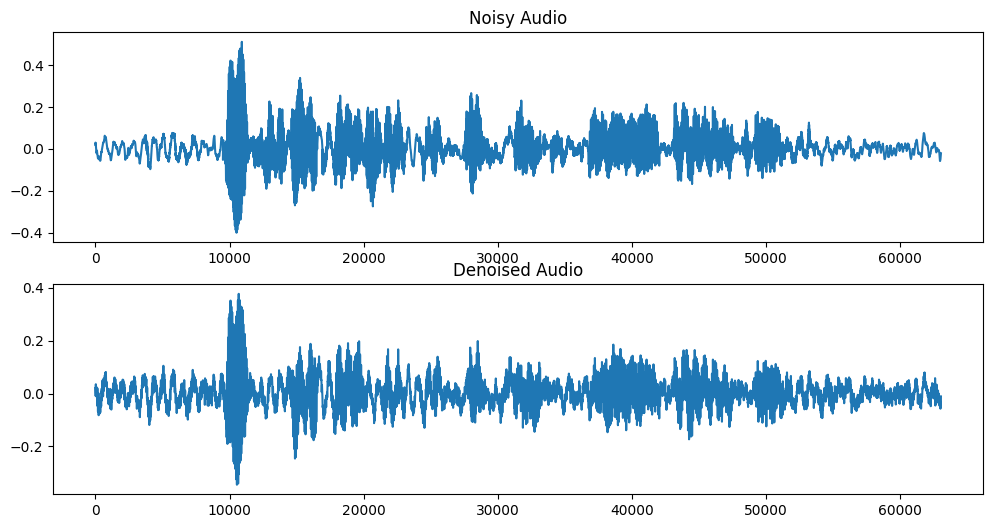

Example 1:
Original noisy audio shape: (122400,)


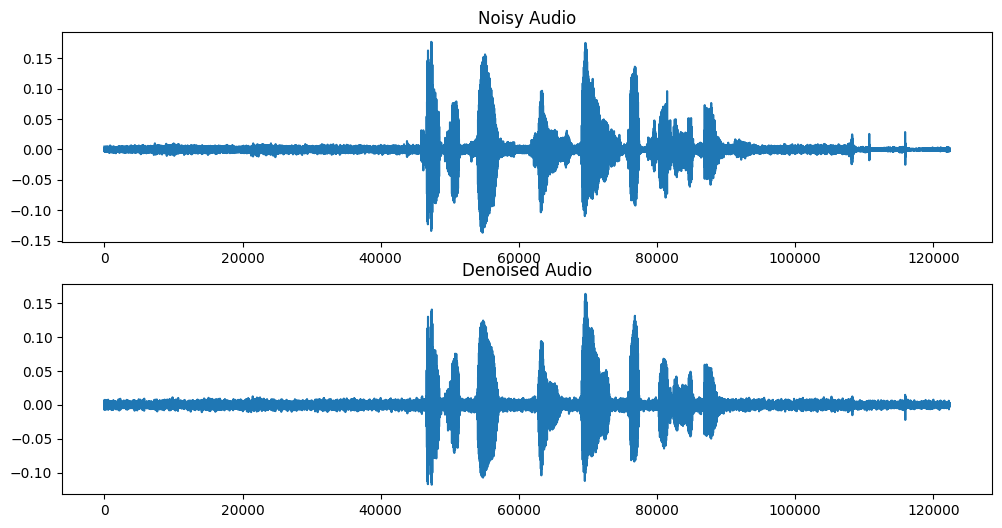

Example 2:
Original noisy audio shape: (36647,)


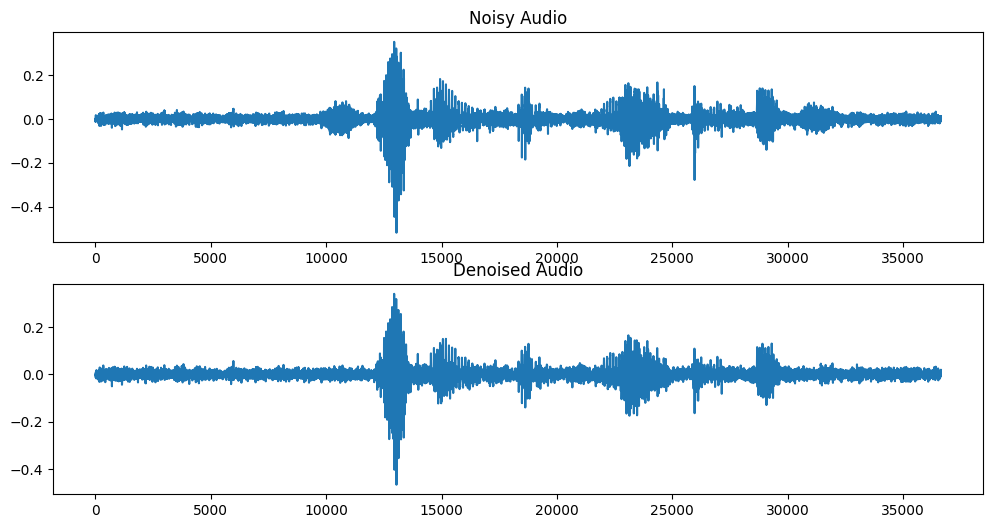

Example 3:
Original noisy audio shape: (102080,)


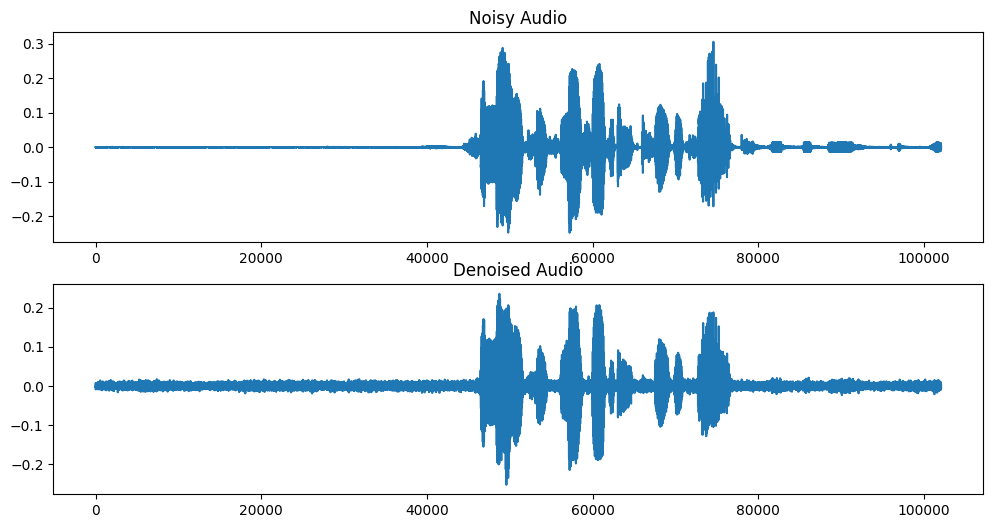

Example 4:
Original noisy audio shape: (122400,)


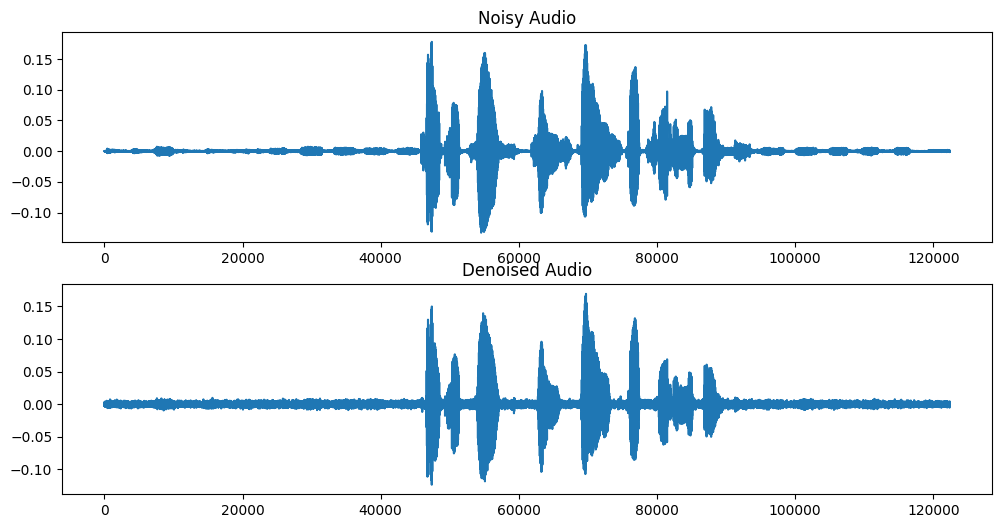

In [33]:
from IPython.display import Audio, display
# get 5 examples from the dataset
sample_ds = full_ds.shuffle(seed=42).select(range(5))
print("Sample dataset:")
print(sample_ds)
print("Sample dataset features:")
print(sample_ds.features)
# Define a function to apply DCT denoising
def denoise_example(example):
    # Denoise the noisy audio
    noisy_audio = example["noisy"]["array"]
    print(f"Original noisy audio shape: {noisy_audio}")
    # Convert to numpy array
    noisy_audio = np.array(noisy_audio, dtype=float)
    # Apply DCT denoising
    denoised_audio = dct_denoise(noisy_audio, threshold_factor=0.06)
    
    # Store the denoised audio back in the example
    example["denoised"] = denoised_audio
    return example
# Apply the denoising function to the sample dataset
sample_ds = sample_ds.map(denoise_example)
# Print and display the also listen denoised examples
for i, example in enumerate(sample_ds):
    print(f"Example {i}:")
    print(f"Original noisy audio shape: {example['noisy']['array'].shape}")
    display(Audio(example["noisy"]["array"], rate=16000))
    # Listen to the denoised audio
    display(Audio(example["denoised"], rate=16000))
    # Plot the original and denoised audio
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(example["noisy"]["array"])
    plt.title("Noisy Audio")
    plt.subplot(2, 1, 2)
    plt.plot(example["denoised"])
    plt.title("Denoised Audio")
    plt.show()

